# Installations

**Disclaimer**   
I write this code on mac m1, so it can't be incompatible on Windows Subsystem for Linux or simply on Linux server in terms of dependencies.  
So in case the following cell is not gonna work try to follow **Reproducibility** section of Readme or run one of the following commands:
1. pip3 install -r requirements.txt
2. conda install -r requirements.txt

In [1]:
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install tqdm
!conda install py-xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



# Imports

In [2]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, mutual_info_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

# EDA
We use dataset for credit score classification: https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data

In [3]:
df = pd.read_csv('data/initial_dataset.csv')
print(f"Dataset length: {len(df)}")

Dataset length: 100000


/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3587610027.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/initial_dataset.csv')


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,...,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
df.dtypes

id                           object
customer_id                  object
month                        object
name                         object
age                          object
ssn                          object
occupation                   object
annual_income                object
monthly_inhand_salary       float64
num_bank_accounts             int64
num_credit_card               int64
interest_rate                 int64
num_of_loan                  object
type_of_loan                 object
delay_from_due_date           int64
num_of_delayed_payment       object
changed_credit_limit         object
num_credit_inquiries        float64
credit_mix                   object
outstanding_debt             object
credit_utilization_ratio    float64
credit_history_age           object
payment_of_min_amount        object
total_emi_per_month         float64
amount_invested_monthly      object
payment_behaviour            object
monthly_balance              object
credit_score                

In [7]:
df.isnull().sum()

id                              0
customer_id                     0
month                           0
name                         9985
age                             0
ssn                             0
occupation                      0
annual_income                   0
monthly_inhand_salary       15002
num_bank_accounts               0
num_credit_card                 0
interest_rate                   0
num_of_loan                     0
type_of_loan                11408
delay_from_due_date             0
num_of_delayed_payment       7002
changed_credit_limit            0
num_credit_inquiries         1965
credit_mix                      0
outstanding_debt                0
credit_utilization_ratio        0
credit_history_age           9030
payment_of_min_amount           0
total_emi_per_month             0
amount_invested_monthly      4479
payment_behaviour               0
monthly_balance              1200
credit_score                    0
dtype: int64

## Dealing with missing values and problematic types

### month
Let's add numeric column with month number, so sorting data in the future would be easy

In [8]:
df.month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [9]:
months_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

In [10]:
df['month_number'] = df.month.map(months_mapping)
df['month_number'].head(10)

0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    1
9    2
Name: month_number, dtype: int64

### name column
All customers with same id have the same name. So let's try to fill empty names using customer_id

In [11]:
print(f"Initiall number of empty names: {df[['name']].isna().sum().values[0]}")

Initiall number of empty names: 9985


In [12]:
df['name'] = df[['customer_id', 'name']].groupby('customer_id').fillna(method='bfill')
df['name'] = df[['customer_id', 'name']].groupby('customer_id').fillna(method='ffill')
print(f'Number of empty names after fillna: {df["name"].isna().sum()}')

/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3461443390.py:1: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df['name'] = df[['customer_id', 'name']].groupby('customer_id').fillna(method='bfill')
/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3461443390.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['name'] = df[['customer_id', 'name']].groupby('customer_id').fillna(method='bfill')
/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3461443390.py:2: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single valu

Number of empty names after fillna: 0


### monthly_inhand_salary
Now we want to fill monthly_inhand_salary column. 
* We assume that it depends on annual_income column. 
* Unfortunately annual_income columns is of object and not numeric.
* If we try to cast annual income to numeric type we get an error:

In [13]:
try:
    df['annual_income'] = df['annual_income'].apply(pd.to_numeric)
except Exception as e:
    print(e)

Unable to parse string "34847.84_" at position 0


Let's see what are those problematic values we are dealing with:

In [14]:
problematic_values = df[df['annual_income'].apply(pd.to_numeric, errors='coerce').isna()]['annual_income'].values
problematic_values

array(['34847.84_', '30689.89_', '35547.71_', ..., '37188.1_',
       '39628.99_', '39628.99_'], dtype=object)

It seems like all of those problematic values have "_" in the end. Let's check it

In [15]:
for val in problematic_values:
    assert '_' == val[-1]

Let's check that we can cast all of those values to float if we delete "_" in the end

In [16]:
for val in problematic_values:
    float(val[:-1])

So now let's write function that will cast annual_income column to numeric

In [17]:
def custom_to_numeric(value):
    if isinstance(value, str): 
        if value[-1] == '_':
            return float(value[:-1])
    return float(value)

In [18]:
df['annual_income'] = df['annual_income'].apply(custom_to_numeric)
df['annual_income'].dtype

dtype('float64')

Let's now fill the values for monthly_inhand_salary column.  
Let's check how monthly_inhand_salary depend on annual_income. To do that let's see the proportion between those values

In [19]:
not_empty_montly_salary_index = df['monthly_inhand_salary'].dropna().index
proportion = df['annual_income'][not_empty_montly_salary_index] / df['monthly_inhand_salary'][not_empty_montly_salary_index]
proportion.describe()

count    84998.000000
mean        67.244578
std        846.095019
min          8.089821
25%         11.553886
50%         12.025936
75%         12.553691
max      54110.522117
dtype: float64

In [20]:
np.quantile(proportion, 0.1), np.quantile(proportion, 0.9)

(np.float64(10.884076704509429), np.float64(13.568605658582612))

I assume there are some extreme values of annual_income, because mean is 67, but as you can see most of the values are between 10 and 13 with median being around 12, which makes sence, because year has 12 months. So let's fill empty values of this column with **annual_income/12**

In [21]:
df['monthly_inhand_salary'] = df['monthly_inhand_salary'].fillna(df['annual_income']/12)

### num_of_loan
This column represents the number of loans taken from the bank.  
This column should be numerical, but it's an object. Let's fix it.

In [22]:
s = df['num_of_loan'].unique()
s.sort()
s

array(['-100', '0', '0_', '1', '100', '1001', '1002', '1006', '1008',
       '101', '1014', '1015', '1017', '1019', '1023', '1027_', '103',
       '1030', '1035', '1036', '1039', '1040', '1046', '1047', '1048',
       '1053', '1054', '1070', '1074', '1077', '1085', '1088', '1091',
       '1094', '1096', '1103', '1106', '1110', '1112', '1127', '1129',
       '1129_', '1131', '1131_', '1132_', '1135', '1137', '1150', '1151',
       '1152', '1154', '1159', '1160', '1171_', '1178', '1181', '1182',
       '1185_', '1187', '1189', '119', '1196', '1202', '1204', '1209',
       '1210', '1214', '1216', '1217', '1219_', '1222', '1225', '1225_',
       '1227', '1228', '123', '1236', '1241', '1257', '1259', '126',
       '1265', '1271', '1274', '1279', '1289', '1294', '1296', '1297',
       '1298', '1300', '1302', '1307', '1311_', '1312', '1313', '1318',
       '1319', '131_', '132', '1320', '1320_', '1329', '1340', '1345',
       '1347_', '1348', '1353', '1354', '1359', '136', '1363', '1365',
   

We once again see that some of the values have underscores in the end. We will cast this field to numeric using the same function

In [23]:
df['num_of_loan'] = df['num_of_loan'].apply(custom_to_numeric)
df['num_of_loan'].dtype

dtype('float64')

Also we see that num_of_loan can be negative, which is strange.   
Let's look at types of loans correspoding to num_of_loan == -100:

In [24]:
num_of_loans_check = df[df['num_of_loan'] == -100][['num_of_loan', 'customer_id', 'name']]
num_of_loans_check

,num_of_loan,customer_id,name
31,-100.0,CUS_0xb891,Jasond
34,-100.0,CUS_0x1cdb,Deepaa
39,-100.0,CUS_0x1cdb,Deepaa
53,-100.0,CUS_0x284a,Nadiaq
61,-100.0,CUS_0x5407,Annk
...,...,...,...
99877,-100.0,CUS_0x3855,Xolai
99901,-100.0,CUS_0x4986,Charles Abbotta
99902,-100.0,CUS_0x4986,Charles Abbotta
99969,-100.0,CUS_0xf16,Maria Sheahanb


Let's look at some of the clients with num_of_loan = -100:

In [25]:
df[df['customer_id'] == 'CUS_0x5407'][['month', 'type_of_loan', 'num_of_loan']]

,month,type_of_loan,num_of_loan
56,January,"Not Specified, Auto Loan, and Student Loan",3.0
57,February,"Not Specified, Auto Loan, and Student Loan",3.0
58,March,"Not Specified, Auto Loan, and Student Loan",3.0
59,April,"Not Specified, Auto Loan, and Student Loan",3.0
60,May,"Not Specified, Auto Loan, and Student Loan",3.0
61,June,"Not Specified, Auto Loan, and Student Loan",-100.0
62,July,"Not Specified, Auto Loan, and Student Loan",3.0
63,August,"Not Specified, Auto Loan, and Student Loan",3.0


In [26]:
df[df['customer_id'] == 'CUS_0x4157'][['month', 'type_of_loan', 'num_of_loan']]

,month,type_of_loan,num_of_loan
64,January,"Personal Loan, Debt Consolidation Loan, and Au...",-100.0
65,February,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
66,March,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
67,April,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
68,May,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
69,June,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
70,July,"Personal Loan, Debt Consolidation Loan, and Au...",3.0
71,August,"Personal Loan, Debt Consolidation Loan, and Au...",3.0


We can see that in those cases -100 is invalid. So let's set NaN value instead of -100:

In [27]:
df.loc[df['num_of_loan'] == -100, 'num_of_loan'] = np.nan

Also let's look at other values of num_of_loan

In [28]:
df['num_of_loan'].value_counts(sort=True).head(20)

num_of_loan
3.0       15104
2.0       15032
4.0       14743
0.0       10930
1.0       10606
6.0        7803
7.0        7344
5.0        7197
9.0        3702
8.0        3191
1150.0        4
1228.0        3
1480.0        3
288.0         3
773.0         3
430.0         3
227.0         2
1131.0        2
192.0         2
284.0         2
Name: count, dtype: int64

This data looks suspicious. What person would have 1000+ loans? Let's look at normalisation of this data:

In [29]:
display(df['num_of_loan'].value_counts(normalize=True, sort=True).head(10))
print(f"% of num of loans from 0 to 9: {df['num_of_loan'].value_counts(normalize=True, sort=True).head(10).sum()}")

num_of_loan
3.0    0.157130
2.0    0.156381
4.0    0.153375
0.0    0.113707
1.0    0.110337
6.0    0.081176
7.0    0.076401
5.0    0.074872
9.0    0.038513
8.0    0.033197
Name: proportion, dtype: float64

% of num of loans from 0 to 9: 0.9950896758353793


We can see that over 99.5% of rows has number of loans < 10. So let's assume that number of loans > 10 is a mistake and let's set NaN value instead of any value greater than 9:

In [30]:
df.loc[df['num_of_loan'] > 9, 'num_of_loan'] = np.nan

To fill missing values let's just make num_of_loan equal to number of loans avaliable in the previous month. If there is no info about the previous months, we will take the next month.

In [31]:
df['num_of_loan'].isna().sum()

np.int64(4348)

In [32]:
df['num_of_loan'] = df[['customer_id', 'num_of_loan', 'month_number']].sort_values('month_number').groupby('customer_id').fillna(method='ffill').fillna(method='bfill').sort_index()['num_of_loan']

/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3368487835.py:1: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df['num_of_loan'] = df[['customer_id', 'num_of_loan', 'month_number']].sort_values('month_number').groupby('customer_id').fillna(method='ffill').fillna(method='bfill').sort_index()['num_of_loan']
/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/3368487835.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['num_of_loan'] = df[['customer_id', 'num_of_loan', 'month_number']].sort_values('month_number').groupby('customer_id').fillna(method='ffill').fillna(method='bfill').sort_index()['num_of_loan']


In [33]:
df['num_of_loan'].isna().sum()

np.int64(0)

### type_of_loan

In [34]:
all_loans_strings = list(df['type_of_loan'].dropna().unique())
all_loans_strings[:10]

['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
 'Credit-Builder Loan',
 'Auto Loan, Auto Loan, and Not Specified',
 'Not Specified',
 'Credit-Builder Loan, and Mortgage Loan',
 'Not Specified, Auto Loan, and Student Loan',
 'Personal Loan, Debt Consolidation Loan, and Auto Loan',
 'Not Specified, and Payday Loan',
 'Credit-Builder Loan, Personal Loan, and Auto Loan',
 'Payday Loan, and Payday Loan']

We can see that values are really different, but we are interested in all unique kinds of types:

In [35]:
unique_types = set()
for string_ in all_loans_strings:
    for type_ in string_.split(','):
        n_type = type_.replace(" and ","").strip()
        unique_types.add(n_type)
print(unique_types)

{'Credit-Builder Loan', 'Debt Consolidation Loan', 'Personal Loan', 'Payday Loan', 'Auto Loan', 'Not Specified', 'Mortgage Loan', 'Home Equity Loan', 'Student Loan'}


Let's look closer at this column, that represents the types of loan taken by a person. I assume we can fill empty values by using previuos data from the same client.



In [36]:
clients_with_nan_loans = list(df[df['type_of_loan'].isna()]['customer_id'].unique())
clients_with_nan_loans[:5]

['CUS_0x1cdb', 'CUS_0x95ee', 'CUS_0x6070', 'CUS_0x3553', 'CUS_0x132f']

In [37]:
df[df['customer_id'] == clients_with_nan_loans[0]][['type_of_loan', 'num_of_loan']]

,type_of_loan,num_of_loan
32,NaN,0.0
33,NaN,0.0
34,NaN,0.0
35,NaN,0.0
36,NaN,0.0
37,NaN,0.0
38,NaN,0.0
39,NaN,0.0


In [38]:
df[df['customer_id'] == clients_with_nan_loans[-2]][['type_of_loan', 'num_of_loan']]

,type_of_loan,num_of_loan
99904,NaN,0.0
99905,NaN,0.0
99906,NaN,0.0
99907,NaN,0.0
99908,NaN,0.0
99909,NaN,0.0
99910,NaN,0.0
99911,NaN,0.0


It seems like type_of_loan is NaN if num_of_loan == 0. Let's check that:

In [39]:
customers_groups = df.groupby('customer_id')
counter = 0
for cid in clients_with_nan_loans:
    group = customers_groups.get_group(cid)
    if not (all(group['type_of_loan'].fillna(0.0) == group['num_of_loan'])):
        counter += 1
        if counter == 30:
            display(group[['customer_id', 'type_of_loan', 'num_of_loan', 'month_number']])
print(counter)

/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/1229599172.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if not (all(group['type_of_loan'].fillna(0.0) == group['num_of_loan'])):


,customer_id,type_of_loan,num_of_loan,month_number
57504,CUS_0xc4e7,NaN,3.0,1
57505,CUS_0xc4e7,NaN,0.0,2
57506,CUS_0xc4e7,NaN,0.0,3
57507,CUS_0xc4e7,NaN,0.0,4
57508,CUS_0xc4e7,NaN,0.0,5
57509,CUS_0xc4e7,NaN,0.0,6
57510,CUS_0xc4e7,NaN,0.0,7
57511,CUS_0xc4e7,NaN,0.0,8


59


/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/1229599172.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if not (all(group['type_of_loan'].fillna(0.0) == group['num_of_loan'])):


In [40]:
df.type_of_loan.isna().sum()

np.int64(11408)

As we can see it's possible that type_of_loan is NaN, but num_of_loan is reasonable values. 
In this case we will fill type_of_loan "Not Specified" value, and otherwise we will create new value "No loans"

In [41]:
no_loans_index = df[df['num_of_loan'] == 0.0].index
no_loans_index

Index([   32,    33,    34,    35,    36,    37,    38,    39,    40,    41,
       ...
       99910, 99911, 99936, 99937, 99938, 99939, 99940, 99941, 99942, 99943],
      dtype='int64', length=11409)

In [42]:
df.loc[no_loans_index, ['type_of_loan']] = "No loans"

In [43]:
df[df['customer_id'] == clients_with_nan_loans[0]][['type_of_loan', 'num_of_loan']]

,type_of_loan,num_of_loan
32,No loans,0.0
33,No loans,0.0
34,No loans,0.0
35,No loans,0.0
36,No loans,0.0
37,No loans,0.0
38,No loans,0.0
39,No loans,0.0


In [44]:
still_nulls = df.type_of_loan.isna()
df[still_nulls][['customer_id', 'type_of_loan', 'num_of_loan', 'month_number']]

,customer_id,type_of_loan,num_of_loan,month_number
712,CUS_0x3861,NaN,2.0,1
2496,CUS_0x79b,NaN,1.0,1
2984,CUS_0xa560,NaN,3.0,1
6832,CUS_0x6b15,NaN,3.0,1
6880,CUS_0x29d2,NaN,4.0,1
...,...,...,...,...
89232,CUS_0xc317,NaN,6.0,1
89432,CUS_0x58b2,NaN,4.0,1
89640,CUS_0x2b3c,NaN,3.0,1
92208,CUS_0x30c1,NaN,3.0,1


In [45]:
df.type_of_loan = df.type_of_loan.fillna('Not Specified')
df[still_nulls][['customer_id', 'type_of_loan', 'num_of_loan', 'month_number']]

,customer_id,type_of_loan,num_of_loan,month_number
712,CUS_0x3861,Not Specified,2.0,1
2496,CUS_0x79b,Not Specified,1.0,1
2984,CUS_0xa560,Not Specified,3.0,1
6832,CUS_0x6b15,Not Specified,3.0,1
6880,CUS_0x29d2,Not Specified,4.0,1
...,...,...,...,...
89232,CUS_0xc317,Not Specified,6.0,1
89432,CUS_0x58b2,Not Specified,4.0,1
89640,CUS_0x2b3c,Not Specified,3.0,1
92208,CUS_0x30c1,Not Specified,3.0,1


Let's also turn all unique values of type of loans into individual columns. 

In [46]:
unique_types

{'Auto Loan',
 'Credit-Builder Loan',
 'Debt Consolidation Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Not Specified',
 'Payday Loan',
 'Personal Loan',
 'Student Loan'}

In [47]:
for utype in unique_types:
    new_column_name = f"loan_type_{utype.lower().replace(' ', '_')}"
    df[new_column_name] = df.type_of_loan.str.contains(utype).astype(int)

### credit_history_age
Represents the age of credit history of the person

In [48]:
df.credit_history_age.head()

0    22 Years and 1 Months
1                      NaN
2    22 Years and 3 Months
3    22 Years and 4 Months
4    22 Years and 5 Months
Name: credit_history_age, dtype: object

In [49]:
print(f"Empty values count: {df.credit_history_age.isna().sum()}")

Empty values count: 9030


In [50]:
df.credit_history_age.value_counts()

credit_history_age
15 Years and 11 Months    446
19 Years and 4 Months     445
19 Years and 5 Months     444
17 Years and 11 Months    443
19 Years and 3 Months     441
                         ... 
0 Years and 3 Months       20
0 Years and 2 Months       15
33 Years and 7 Months      14
33 Years and 8 Months      12
0 Years and 1 Months        2
Name: count, Length: 404, dtype: int64

Let's turn this column into number of months as integer value:

In [51]:
a = np.nan
np.isnan(a)

np.True_

In [52]:
def credit_history_age_to_int(value: str):
    if pd.isnull(value):
        return value
    years_str, months_str = value.split(' and ')
    years = int(years_str.split(' ')[0])
    months = int(months_str.split(' ')[0])
    return 12 * years + months

In [53]:
df['credit_history_age'] = df['credit_history_age'].apply(credit_history_age_to_int)

Let's also fill empty values using customer info we gather from other rows:

In [54]:
df[df['credit_history_age'].isna()][['customer_id', 'credit_history_age']]

,customer_id,credit_history_age
1,CUS_0xd40,NaN
7,CUS_0xd40,NaN
19,CUS_0x2dbc,NaN
40,CUS_0x95ee,NaN
42,CUS_0x95ee,NaN
...,...,...
99944,CUS_0x51b3,NaN
99963,CUS_0x372c,NaN
99968,CUS_0xf16,NaN
99975,CUS_0xf16,NaN


In [55]:
df[df['customer_id'] == 'CUS_0xd40'][['customer_id', 'month_number', 'credit_history_age']]

,customer_id,month_number,credit_history_age
0,CUS_0xd40,1,265.0
1,CUS_0xd40,2,NaN
2,CUS_0xd40,3,267.0
3,CUS_0xd40,4,268.0
4,CUS_0xd40,5,269.0
5,CUS_0xd40,6,270.0
6,CUS_0xd40,7,271.0
7,CUS_0xd40,8,NaN


In [56]:
df['credit_history_age'].isna().sum()

np.int64(9030)

In [57]:
def fill_credit_history_age(group):
    group = group.sort_values(by='month_number').reset_index(drop=True)
    
    start_index = group['credit_history_age'].first_valid_index()
    if start_index is not None:  
        start_age = group.loc[start_index, 'credit_history_age']
        start_month = group.loc[start_index, 'month_number']
        
        group['credit_history_age'] = group.apply(
            lambda row: start_age + row['month_number'] - start_month if pd.isna(row['credit_history_age']) else row['credit_history_age'],
            axis=1
        )
    return group

In [58]:
df = df.groupby('customer_id', group_keys=False).apply(fill_credit_history_age)

/var/folders/9z/rhfc541d14q5klxp9lqvgx8m0000gq/T/ipykernel_51910/2784598098.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('customer_id', group_keys=False).apply(fill_credit_history_age)


In [59]:
df['credit_history_age'].isna().sum()

np.int64(0)

## num_credit_inquiries
Represents the number of credit card inquiries

In [60]:
df.num_credit_inquiries.isnull().sum()

np.int64(1965)

In [61]:
df[df.num_credit_inquiries.isnull()][['customer_id', 'num_credit_inquiries']]

,customer_id,num_credit_inquiries
4,CUS_0x1018,NaN
2,CUS_0x1041,NaN
7,CUS_0x1051,NaN
2,CUS_0x105b,NaN
0,CUS_0x107c,NaN
...,...,...
4,CUS_0xfb4,NaN
1,CUS_0xff4,NaN
3,CUS_0xff4,NaN
0,CUS_0xff6,NaN


In [62]:
df[df.customer_id == 'CUS_0xff6'][['customer_id', 'num_credit_inquiries']]

,customer_id,num_credit_inquiries
0,CUS_0xff6,NaN
1,CUS_0xff6,2.0
2,CUS_0xff6,2.0
3,CUS_0xff6,2.0
4,CUS_0xff6,2.0
5,CUS_0xff6,2.0
6,CUS_0xff6,2.0
7,CUS_0xff6,2.0


As you can see for most cases empty values can be just filled with mean value for the customer. But before we fill them let's look at values counts

In [63]:
df[df.num_credit_inquiries == 2536.0][['customer_id', 'num_credit_inquiries']]

,customer_id,num_credit_inquiries
6,CUS_0x799e,2536.0


In [64]:
df.num_credit_inquiries.value_counts(sort=True).sort_index().head(20)

num_credit_inquiries
0.0      6972
1.0      7588
2.0      8028
3.0      8890
4.0     11271
5.0      5693
6.0      8111
7.0      8058
8.0      7866
9.0      5283
10.0     4936
11.0     5051
12.0     4571
13.0     1480
14.0     1039
15.0      808
16.0      456
17.0      284
26.0        1
29.0        1
Name: count, dtype: int64

In [65]:
top_vals_proc = (df.num_credit_inquiries.value_counts(normalize=True, sort=True).head(20).sum() * 100).round(3)
print(f"Values from 1 to 17 takes {top_vals_proc}% of the values")

Values from 1 to 17 takes 98.325% of the values


Let's look at connection between num_credit_inquiries and credit_score:

In [66]:
under_18_df = df[df['num_credit_inquiries'] < 18]
over_18_df = df[df['num_credit_inquiries'] >= 18]
len(under_18_df), len(over_18_df)

(96385, 1650)

In [67]:
corrs = {}
corrs['good_all'] = df.num_credit_inquiries.corr(df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))
corrs['good_<18'] = under_18_df.num_credit_inquiries.corr(under_18_df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))
corrs['good_>18'] = over_18_df.num_credit_inquiries.corr(over_18_df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))


corrs['standard_all'] = df.num_credit_inquiries.corr(df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))
corrs['standard_<18'] = under_18_df.num_credit_inquiries.corr(under_18_df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))
corrs['standard_>18'] = over_18_df.num_credit_inquiries.corr(over_18_df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))

corrs['poor_all'] = df.num_credit_inquiries.corr(df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))
corrs['poor_<18'] = under_18_df.num_credit_inquiries.corr(under_18_df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))
corrs['poor_>18'] = over_18_df.num_credit_inquiries.corr(over_18_df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))


for key in corrs:
    corrs[key] = float(corrs[key].round(4))

In [68]:
corrs

{'good_all': -0.0079,
 'good_<18': -0.3007,
 'good_>18': -0.0189,
 'standard_all': -0.0031,
 'standard_<18': -0.1272,
 'standard_>18': -0.0286,
 'poor_all': 0.0101,
 'poor_<18': 0.3936,
 'poor_>18': 0.0474}

We can see that on average correlation works much better if we don't look at values greater than 18. But maybe we can fix the situation without removing values higher than 17 by taking np.log from this column:

In [69]:
df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}).corr(df.num_credit_inquiries)
np.log1p(df.num_credit_inquiries).corr(df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))

np.float64(-0.20497975128047857)

In [70]:
corrs = {}
corrs['good_all'] = np.log1p(df.num_credit_inquiries).corr(df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))
corrs['good_<18'] = np.log1p(under_18_df.num_credit_inquiries).corr(under_18_df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))
corrs['good_>18'] = np.log1p(over_18_df.num_credit_inquiries).corr(over_18_df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0}))


corrs['standard_all'] = np.log1p(df.num_credit_inquiries).corr(df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))
corrs['standard_<18'] = np.log1p(under_18_df.num_credit_inquiries).corr(under_18_df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))
corrs['standard_>18'] = np.log1p(over_18_df.num_credit_inquiries).corr(over_18_df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1}))


corrs['poor_all'] = np.log1p(df.num_credit_inquiries).corr(df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))
corrs['poor_<18'] = np.log1p(under_18_df.num_credit_inquiries).corr(under_18_df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))
corrs['poor_>18'] = np.log1p(over_18_df.num_credit_inquiries).corr(over_18_df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0}))


for key in corrs:
    corrs[key] = float(corrs[key].round(4))

In [71]:
corrs

{'good_all': -0.205,
 'good_<18': -0.2833,
 'good_>18': -0.0299,
 'standard_all': -0.0665,
 'standard_<18': -0.093,
 'standard_>18': -0.034,
 'poor_all': 0.246,
 'poor_<18': 0.3413,
 'poor_>18': 0.0627}

We see that correlation grew in all cases for the initial dataset, so let's fill apply log1p to this column.   
Before we do that we need to fill nulls in the data and I think that it make sense to fill it with median of the class because of cases like this:

In [72]:
df[df.customer_id == 'CUS_0x799e'][['customer_id', 'num_credit_inquiries']]

,customer_id,num_credit_inquiries
0,CUS_0x799e,0.0
1,CUS_0x799e,0.0
2,CUS_0x799e,0.0
3,CUS_0x799e,0.0
4,CUS_0x799e,0.0
5,CUS_0x799e,0.0
6,CUS_0x799e,2536.0
7,CUS_0x799e,NaN


As you can see for this client num_credit_inquiries is almost always 0, then for some reason it absurdly high and then it's NaN. So it we use average value NaN gonna be replaced with 2536/7 = 362 which is still very uncommon value. So let's we will use median to fill NaNs.

In [73]:
df.loc[df['num_credit_inquiries'] > 17, 'num_credit_inquiries'] = np.nan

In [74]:
df['num_credit_inquiries'] = df.groupby('customer_id')['num_credit_inquiries'].transform(lambda x: x.fillna(x.median()))

In [75]:
df['num_credit_inquiries'] = np.log1p(df['num_credit_inquiries'])

## num_of_delayed_payment
Represents the average number of payments delayed by a person

In [76]:
df.num_of_delayed_payment.unique()[:40]

array(['25', '23', '28', '26', '1749', '16', '18', '19', '7', '9', '8',
       '12', nan, '17_', '15', '13', '10', '22', '20', '2', '1', '5',
       '11', '17', '15_', '14', '4', '3', '6', '21', '8_', '11_', '2230',
       '0', '24', '18_', '-2', '19_', '1636', '20_'], dtype=object)

As we can see this column has the same issue with underscores. Let's fix it

In [77]:
df['num_of_delayed_payment'] = df['num_of_delayed_payment'].apply(custom_to_numeric)
df['num_of_delayed_payment'].dtype

dtype('float64')

Now let's look closer at the values:

In [78]:
print(f"Total number of unique values: {df.num_of_delayed_payment.nunique()}")
df.num_of_delayed_payment.value_counts().head(40)

Total number of unique values: 711


num_of_delayed_payment
 19.0      5481
 17.0      5412
 16.0      5312
 10.0      5309
 15.0      5237
 18.0      5216
 20.0      5089
 12.0      5059
 9.0       4981
 8.0       4873
 11.0      4810
 14.0      4193
 13.0      4036
 21.0      2553
 7.0       2385
 22.0      2339
 6.0       2321
 5.0       2091
 23.0      2028
 3.0       1931
 4.0       1838
 2.0       1810
 24.0      1701
 25.0      1665
 1.0       1636
 0.0       1609
 26.0       322
-1.0        316
 27.0       250
-2.0        234
 28.0       131
-3.0         94
 3484.0       4
 4211.0       3
 1946.0       3
 2801.0       2
 2707.0       2
 2671.0       2
 674.0        2
 2131.0       2
Name: count, dtype: int64

In [79]:
df[df.num_of_delayed_payment == 4211.0][['customer_id', 'num_of_delayed_payment']]

,customer_id,num_of_delayed_payment
6,CUS_0x12cc,4211.0
7,CUS_0x663d,4211.0
1,CUS_0x69d5,4211.0


In [80]:
df[df.customer_id == "CUS_0x12cc"][['customer_id', 'num_of_delayed_payment']]

,customer_id,num_of_delayed_payment
0,CUS_0x12cc,9.0
1,CUS_0x12cc,10.0
2,CUS_0x12cc,NaN
3,CUS_0x12cc,10.0
4,CUS_0x12cc,NaN
5,CUS_0x12cc,10.0
6,CUS_0x12cc,4211.0
7,CUS_0x12cc,12.0


For me it seems like number of delayed payments greater than 30 is completely crazy and is a mistake.   
Let's look at sorted values of num_of_delayed_payment:

In [81]:
df.num_of_delayed_payment.value_counts().sort_index().head(40)

num_of_delayed_payment
-3.0       94
-2.0      234
-1.0      316
 0.0     1609
 1.0     1636
 2.0     1810
 3.0     1931
 4.0     1838
 5.0     2091
 6.0     2321
 7.0     2385
 8.0     4873
 9.0     4981
 10.0    5309
 11.0    4810
 12.0    5059
 13.0    4036
 14.0    4193
 15.0    5237
 16.0    5312
 17.0    5412
 18.0    5216
 19.0    5481
 20.0    5089
 21.0    2553
 22.0    2339
 23.0    2028
 24.0    1701
 25.0    1665
 26.0     322
 27.0     250
 28.0     131
 46.0       1
 47.0       1
 49.0       1
 52.0       1
 72.0       1
 80.0       1
 84.0       1
 85.0       1
Name: count, dtype: int64

I'd say let's assume that any value greater than 28 is a mistake and we will swap it with NaN.
After that let's fill NaNs with average for customer (we will also turn average into integer)

In [82]:
df.loc[df['num_of_delayed_payment'] > 28, 'num_of_delayed_payment'] = np.nan

In [83]:
df['num_of_delayed_payment'] = df.groupby('customer_id')['num_of_delayed_payment'].transform(lambda x: x.fillna(int(x.mean())))

## amount_invested_monthly
Represents the monthly amount invested by the customer (in USD)

In [84]:
df.amount_invested_monthly.isna().sum()

np.int64(4479)

In [85]:
df[df.amount_invested_monthly.isna()].amount_invested_monthly

2    NaN
3    NaN
4    NaN
4    NaN
2    NaN
    ... 
0    NaN
1    NaN
6    NaN
5    NaN
4    NaN
Name: amount_invested_monthly, Length: 4479, dtype: object

First let's look at weird values (negative, strings, etc):

In [86]:
for el in list(df.amount_invested_monthly.unique()):
    try:
        if isinstance(float(el), float):
            if not float(el) >= 0:
                print(el)
    except:
        print(el)

nan
__10000__


In [87]:
df.amount_invested_monthly.value_counts()

amount_invested_monthly
__10000__             4305
0.0                    169
244.75028300769162       1
43.696384366931426       1
367.83349212231786       1
                      ... 
76.53803865050956        1
185.4727815721931        1
138.99426812931569       1
105.72664789066962       1
42.57571978536272        1
Name: count, Length: 91049, dtype: int64

Let's drop \_\_10000__ value and look at distribution of this field

In [88]:
smaller_df = np.float64(df[(df.amount_invested_monthly != '__10000__') & (- df.amount_invested_monthly.isna())].amount_invested_monthly)
smaller_df.sort()
smaller_df[::-1].round(4)[:20]

array([1977.3261, 1961.2189, 1944.5207, 1941.2375, 1903.08  , 1901.7917,
       1890.8558, 1887.5352, 1885.6453, 1878.5039, 1860.9197, 1816.177 ,
       1804.3557, 1804.3325, 1804.2335, 1797.6301, 1785.7868, 1775.048 ,
       1756.9619, 1756.577 ])

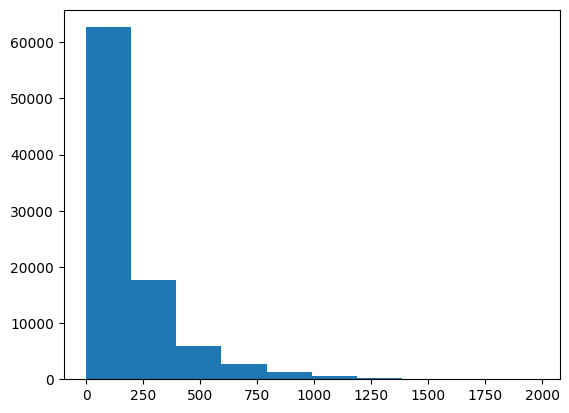

In [89]:
plt.hist(smaller_df)
plt.show() 

We can see that maximal value for investment is 1977.3261 and most of the values are between 0 and 1000. So it doesn't make sence to turn \_\_10000__ into 10000. To be sure of that let's take a look at one of the clients that has \_\_10000__ investment:

In [90]:
df[df.amount_invested_monthly == '__10000__'][['customer_id', 'amount_invested_monthly']]

,customer_id,amount_invested_monthly
3,CUS_0x100b,__10000__
3,CUS_0x1011,__10000__
2,CUS_0x1041,__10000__
7,CUS_0x105c,__10000__
1,CUS_0x1063,__10000__
...,...,...
6,CUS_0xfc9,__10000__
6,CUS_0xfdb,__10000__
0,CUS_0xfe4,__10000__
2,CUS_0xff6,__10000__


In [91]:
df[df.customer_id == "CUS_0x100b"][['customer_id', 'amount_invested_monthly']]

,customer_id,amount_invested_monthly
0,CUS_0x100b,397.24184577026637
1,CUS_0x100b,661.6240479398714
2,CUS_0x100b,NaN
3,CUS_0x100b,__10000__
4,CUS_0x100b,758.0831954920012
5,CUS_0x100b,424.0032051421769
6,CUS_0x100b,174.28759775147847
7,CUS_0x100b,617.0792665202719


It's would be very strange if person invested 10000 once and all the other times his investments were around 500$. Of course he could have won the lottery, but in the dataset we see value \_\_10000__ 4305 times, so it's not probably the case.   
So let's swap this value with NaN and then fill all NaNs with averages for the customer. 

In [92]:
df.loc[df['amount_invested_monthly'] == '__10000__', 'amount_invested_monthly'] = np.nan

In [93]:
df['amount_invested_monthly'] = np.float64(df['amount_invested_monthly'])

In [94]:
df['amount_invested_monthly'] = df.groupby('customer_id')['amount_invested_monthly'].transform(lambda x: x.fillna(x.mean()))

One last look at client CUS_0x100b to be sure that his data is fine:

In [95]:
df[df.customer_id == "CUS_0x100b"][['customer_id', 'amount_invested_monthly']]

,customer_id,amount_invested_monthly
0,CUS_0x100b,397.241846
1,CUS_0x100b,661.624048
2,CUS_0x100b,505.386526
3,CUS_0x100b,505.386526
4,CUS_0x100b,758.083195
5,CUS_0x100b,424.003205
6,CUS_0x100b,174.287598
7,CUS_0x100b,617.079267


## monthly_balance
Represents the monthly balance amount of the customer (in USD)

First let's look at weird values (negative, strings, etc):

In [96]:
for el in list(df.monthly_balance.unique()):
    try:
        if isinstance(float(el), float):
            if not float(el) >= 0:
                print(el)
    except:
        print(el)

nan
__-333333333333333333333333333__


\_\_-333333333333333333333333333__ value is an obvious mistake

In [97]:
df[df.monthly_balance == "__-333333333333333333333333333__"][['customer_id', 'monthly_balance']]

,customer_id,monthly_balance
6,CUS_0x288d,__-333333333333333333333333333__
6,CUS_0x2b77,__-333333333333333333333333333__
7,CUS_0x2f7e,__-333333333333333333333333333__
6,CUS_0x41bf,__-333333333333333333333333333__
3,CUS_0x57f3,__-333333333333333333333333333__
1,CUS_0x5a90,__-333333333333333333333333333__
2,CUS_0x85e9,__-333333333333333333333333333__
1,CUS_0x9885,__-333333333333333333333333333__
1,CUS_0xc06e,__-333333333333333333333333333__


In [98]:
df[df.customer_id == "CUS_0x85e9"][['customer_id', 'monthly_balance']]

,customer_id,monthly_balance
0,CUS_0x85e9,291.44457204550986
1,CUS_0x85e9,330.46334419812166
2,CUS_0x85e9,__-333333333333333333333333333__
3,CUS_0x85e9,342.93726629496325
4,CUS_0x85e9,358.3608394045252
5,CUS_0x85e9,280.959039516267
6,CUS_0x85e9,287.6109372328992
7,CUS_0x85e9,343.2938219999582


Let's delete all values like \_\_-333333333333333333333333333__ and swap them with NaNs and then fill NaNs with averages for customer

In [99]:
df.loc[df['monthly_balance'] == '__-333333333333333333333333333__', 'monthly_balance'] = np.nan

In [100]:
df['monthly_balance'] = np.float64(df['monthly_balance'])

In [101]:
df['monthly_balance'] = df.groupby('customer_id')['monthly_balance'].transform(lambda x: x.fillna(x.mean()))

## age
Represents the age of the person

In [102]:
df['age'].value_counts().sort_index()[:20]

age
-500     886
100        1
1004       1
1006       1
1010       1
102        1
1022       1
1024       1
1028       1
1032       1
1033       1
1040       1
1051       1
1053       1
1062       1
1066       1
1070_      1
1083       2
1087       1
109        1
Name: count, dtype: int64

We can see the same issue with underscores. Let's fix it:

In [103]:
df['age'] = df['age'].apply(custom_to_numeric)

In [104]:
df['age'].value_counts().head(50).sort_index().head(80)

age
-500.0      886
 14.0      1175
 15.0      1574
 16.0      1455
 17.0      1502
 18.0      2385
 19.0      2793
 20.0      2744
 21.0      2716
 22.0      2785
 23.0      2654
 24.0      2714
 25.0      2861
 26.0      2945
 27.0      2859
 28.0      2968
 29.0      2735
 30.0      2727
 31.0      2955
 32.0      2884
 33.0      2543
 34.0      2837
 35.0      2866
 36.0      2868
 37.0      2742
 38.0      2994
 39.0      2846
 40.0      2609
 41.0      2785
 42.0      2577
 43.0      2734
 44.0      2824
 45.0      2642
 46.0      1621
 47.0      1227
 48.0      1385
 49.0      1375
 50.0      1273
 51.0      1291
 52.0      1356
 53.0      1354
 54.0      1311
 55.0      1366
 56.0       362
 1753.0       3
 2109.0       3
 3920.0       3
 4494.0       3
 6799.0       4
 8015.0       3
Name: count, dtype: int64

In [105]:
df[df.age == 100][['customer_id', 'age']]

,customer_id,age
4,CUS_0x3b9a,100.0


In [106]:
df[df.customer_id == "CUS_0x3b9a"][['customer_id', 'age']]

,customer_id,age
0,CUS_0x3b9a,32.0
1,CUS_0x3b9a,32.0
2,CUS_0x3b9a,32.0
3,CUS_0x3b9a,32.0
4,CUS_0x3b9a,100.0
5,CUS_0x3b9a,32.0
6,CUS_0x3b9a,32.0
7,CUS_0x3b9a,32.0


We can see some absurd values in this column. Let's swap any age lower than 14 and higher than 56 to NaN and then select median age for the customer. 

In [107]:
df.loc[(df.age < 14) | (df.age > 56), 'age'] = np.nan

In [108]:
df['age'] = df.groupby('customer_id')['age'].transform(lambda x: x.fillna(x.median()))

## ssn
Represents the social security number of a person

In [109]:
df['ssn'].value_counts().sort_index()[:20]

ssn
#F%$D@*&8      5572
000-08-1349       8
000-40-3312       8
000-58-0568       8
000-60-0688       8
000-63-0442       7
000-80-0683       8
000-86-6182       8
000-89-3828       8
000-89-4910       7
000-89-8752       8
000-92-4286       7
000-95-4380       8
001-06-5634       7
001-06-7616       7
001-11-0655       8
001-30-8624       8
001-41-8258       8
001-43-6015       8
001-49-5189       8
Name: count, dtype: int64

In [110]:
df[df.ssn == '#F%$D@*&8'][['customer_id', 'ssn']]

,customer_id,ssn
0,CUS_0x1009,#F%$D@*&8
7,CUS_0x100b,#F%$D@*&8
3,CUS_0x1011,#F%$D@*&8
7,CUS_0x102e,#F%$D@*&8
1,CUS_0x1032,#F%$D@*&8
...,...,...
4,CUS_0xfb8,#F%$D@*&8
5,CUS_0xfcc,#F%$D@*&8
2,CUS_0xfdd,#F%$D@*&8
6,CUS_0xfe5,#F%$D@*&8


In [111]:
df[df.customer_id == "CUS_0x1009"][['customer_id', 'ssn']]

,customer_id,ssn
0,CUS_0x1009,#F%$D@*&8
1,CUS_0x1009,063-67-6938
2,CUS_0x1009,063-67-6938
3,CUS_0x1009,063-67-6938
4,CUS_0x1009,063-67-6938
5,CUS_0x1009,063-67-6938
6,CUS_0x1009,063-67-6938
7,CUS_0x1009,063-67-6938


It seems like some ssns are broken and have value of #F%$D@*&8. Let's swap it for most frequent value for the customer

In [112]:
df.loc[df.ssn == '#F%$D@*&8', 'ssn'] = np.nan

In [113]:
df.ssn = df.groupby('customer_id')['ssn'].transform(lambda x: x.fillna(x.mode().iloc[0]))

The nine-digit SSN is composed of three parts:

1. The first set of three digits is called the Area Number
2. The second set of two digits is called the Group Number
3. The final set of four digits is the Serial Number

Let's delete everything apart from first three numbers (and maybe in the future we will turn it into categorical value)

In [114]:
df.ssn

0    913-74-1218
1    913-74-1218
2    913-74-1218
3    913-74-1218
4    913-74-1218
        ...     
3    832-88-8320
4    832-88-8320
5    832-88-8320
6    832-88-8320
7    832-88-8320
Name: ssn, Length: 100000, dtype: object

In [115]:
df['ssn_area'] = df.ssn.apply(lambda x: x.split('-')[0])

In [116]:
df['ssn_area'].nunique()

1000

## occupation
Represents the occupation of the person

In [117]:
df.occupation.value_counts()

occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

In [118]:
df[df.occupation == '_______'][['customer_id', 'occupation']]

,customer_id,occupation
5,CUS_0x1009,_______
3,CUS_0x1026,_______
3,CUS_0x102d,_______
7,CUS_0x1044,_______
4,CUS_0x104e,_______
...,...,...
6,CUS_0xfe3,_______
1,CUS_0xfe4,_______
4,CUS_0xfe5,_______
5,CUS_0xffc,_______


In [119]:
df[df.customer_id == "CUS_0xfe3"][['customer_id', 'occupation']]

,customer_id,occupation
0,CUS_0xfe3,Media_Manager
1,CUS_0xfe3,Media_Manager
2,CUS_0xfe3,Media_Manager
3,CUS_0xfe3,_______
4,CUS_0xfe3,Media_Manager
5,CUS_0xfe3,Media_Manager
6,CUS_0xfe3,_______
7,CUS_0xfe3,Media_Manager


Let's swap all _______ values with most popular value for the customer

In [120]:
df.loc[df.occupation == '_______', 'occupation'] = np.nan

In [121]:
df.occupation = df.groupby('customer_id')['occupation'].transform(lambda x: x.fillna(x.mode().iloc[0]))

In [122]:
df.occupation.value_counts()

occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Accountant       6744
Scientist        6744
Media_Manager    6720
Developer        6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: count, dtype: int64

In [123]:
df.occupation.isna().sum()

np.int64(0)

## changed_credit_limit
Represents the percentage change in credit card limit

In [124]:
for el in list(df.changed_credit_limit.unique()):
    try:
        if isinstance(float(el), float):
            pass
    except:
        print(el)

_


The only problematic value is "_"

In [125]:
df[df.changed_credit_limit == '_'][['customer_id', 'changed_credit_limit']].sort_values('customer_id')

,customer_id,changed_credit_limit
3,CUS_0x100b,_
0,CUS_0x1015,_
1,CUS_0x1032,_
4,CUS_0x1038,_
7,CUS_0x1051,_
...,...,...
6,CUS_0xfae,_
1,CUS_0xfbd,_
5,CUS_0xfbd,_
5,CUS_0xfdd,_


In [126]:
df[df.customer_id == "CUS_0xfbd"][['customer_id', 'changed_credit_limit']]

,customer_id,changed_credit_limit
0,CUS_0xfbd,19.62
1,CUS_0xfbd,_
2,CUS_0xfbd,19.62
3,CUS_0xfbd,19.62
4,CUS_0xfbd,14.62
5,CUS_0xfbd,_
6,CUS_0xfbd,19.62
7,CUS_0xfbd,25.62


Once again we swap _ with NaNs and fill NaNs with most popular value for the customer

In [127]:
df.loc[df.changed_credit_limit == '_', 'changed_credit_limit'] = np.nan

In [128]:
df.changed_credit_limit = np.float64(df.changed_credit_limit)

In [129]:
df.changed_credit_limit = df.groupby('customer_id')['changed_credit_limit'].transform(lambda x: x.fillna(x.mode().iloc[0]))

In [130]:
df[df.customer_id == "CUS_0xfbd"][['customer_id', 'changed_credit_limit']]

,customer_id,changed_credit_limit
0,CUS_0xfbd,19.62
1,CUS_0xfbd,19.62
2,CUS_0xfbd,19.62
3,CUS_0xfbd,19.62
4,CUS_0xfbd,14.62
5,CUS_0xfbd,19.62
6,CUS_0xfbd,19.62
7,CUS_0xfbd,25.62


## outstanding_debt
Represents the remaining debt to be paid (in USD)

In [131]:
df.outstanding_debt.unique()[:20]

array(['1562.91', '202.68', '202.68_', '1030.2', '473.14', '1233.51',
       '340.22', '340.22_', '2773.09', '849.69', '648.36', '869.59',
       '1852.86', '665.82', '568.21', '706.96', '4913.15', '154.96',
       '1835.67', '1122.46'], dtype=object)

Let's turn this into numerical column with our special function

In [132]:
df['outstanding_debt'] = df['outstanding_debt'].apply(custom_to_numeric)
df['outstanding_debt'].dtype

dtype('float64')

## payment_behaviour
Represents the payment behavior of the customer (in USD)

In [133]:
df.payment_behaviour.unique()[:20]

array(['Low_spent_Large_value_payments',
       'High_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'Low_spent_Small_value_payments',
       'Low_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

In [134]:
df[df.payment_behaviour == '!@9#%8'][['customer_id', 'payment_behaviour']].sort_values('customer_id')

,customer_id,payment_behaviour
3,CUS_0x1000,!@9#%8
5,CUS_0x1009,!@9#%8
2,CUS_0x1013,!@9#%8
6,CUS_0x1015,!@9#%8
2,CUS_0x1018,!@9#%8
...,...,...
5,CUS_0xfd1,!@9#%8
3,CUS_0xfdd,!@9#%8
1,CUS_0xfe4,!@9#%8
2,CUS_0xff6,!@9#%8


In [135]:
df[df.customer_id == 'CUS_0x1009'][['customer_id', 'payment_behaviour']]

,customer_id,payment_behaviour
0,CUS_0x1009,Low_spent_Medium_value_payments
1,CUS_0x1009,High_spent_Medium_value_payments
2,CUS_0x1009,High_spent_Medium_value_payments
3,CUS_0x1009,High_spent_Small_value_payments
4,CUS_0x1009,High_spent_Medium_value_payments
5,CUS_0x1009,!@9#%8
6,CUS_0x1009,High_spent_Medium_value_payments
7,CUS_0x1009,High_spent_Medium_value_payments


Let's delete weird value !@9#%8 and swap it for most popular one for client 

In [136]:
df.loc[df.payment_behaviour == '!@9#%8', 'payment_behaviour'] = np.nan

In [137]:
df.payment_behaviour = df.groupby('customer_id')['payment_behaviour'].transform(lambda x: x.fillna(x.mode().iloc[0]))

In [138]:
df[df.customer_id == 'CUS_0x1009'][['customer_id', 'payment_behaviour']]

,customer_id,payment_behaviour
0,CUS_0x1009,Low_spent_Medium_value_payments
1,CUS_0x1009,High_spent_Medium_value_payments
2,CUS_0x1009,High_spent_Medium_value_payments
3,CUS_0x1009,High_spent_Small_value_payments
4,CUS_0x1009,High_spent_Medium_value_payments
5,CUS_0x1009,High_spent_Medium_value_payments
6,CUS_0x1009,High_spent_Medium_value_payments
7,CUS_0x1009,High_spent_Medium_value_payments


In [139]:
df.payment_behaviour.unique()[:20]

array(['Low_spent_Large_value_payments',
       'High_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'Low_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

## I think this finishes the part  of EDA and we can start features engeneering 

# Features engineering

In [140]:
features_df = deepcopy(df)

In [141]:
features_df.head()

,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,...,loan_type_credit-builder_loan,loan_type_debt_consolidation_loan,loan_type_personal_loan,loan_type_payday_loan,loan_type_auto_loan,loan_type_not_specified,loan_type_mortgage_loan,loan_type_home_equity_loan,loan_type_student_loan,ssn_area
0,0x1628a,CUS_0x1000,January,Alistair Barrf,17.0,913-74-1218,Lawyer,30625.94,2706.161667,6,...,1,0,0,0,0,0,0,1,0,913
1,0x1628b,CUS_0x1000,February,Alistair Barrf,17.0,913-74-1218,Lawyer,30625.94,2552.161667,6,...,1,0,0,0,0,0,0,1,0,913
2,0x1628c,CUS_0x1000,March,Alistair Barrf,17.0,913-74-1218,Lawyer,30625.94,2706.161667,6,...,1,0,0,0,0,0,0,1,0,913
3,0x1628d,CUS_0x1000,April,Alistair Barrf,17.0,913-74-1218,Lawyer,30625.94,2706.161667,6,...,1,0,0,0,0,0,0,1,0,913
4,0x1628e,CUS_0x1000,May,Alistair Barrf,17.0,913-74-1218,Lawyer,30625.94,2706.161667,6,...,1,0,0,0,0,0,0,1,0,913


Let's drop some customer specific or row specific features:
1. id
2. customer_id
3. ssn
5. name
6. type_of_loan

In [142]:
del features_df['id']
del features_df['customer_id']
del features_df['ssn']
del features_df['name']
del features_df['type_of_loan']

## Mutual information of categorical features
Let's check mutual information of the rest of categorical features (on train + validation part of the dataset)

In [143]:
features_df.dtypes[features_df.dtypes == 'object']

month                    object
occupation               object
credit_mix               object
payment_of_min_amount    object
payment_behaviour        object
credit_score             object
ssn_area                 object
dtype: object

In [144]:
categorical_columns = list(features_df.dtypes[features_df.dtypes == 'object'].index)
categorical_columns.remove('credit_score')

In [145]:
mi_scores = []
for column_name in categorical_columns:
    mi_score = mutual_info_score(features_df[column_name], features_df.credit_score)
    unique_vals = features_df[column_name].nunique()
    mi_scores.append((column_name, mi_score, unique_vals))

In [146]:
columns = ['column_name', 'mutual_info_score', 'column_n_unique_vals']
mi_scores_df = pd.DataFrame(mi_scores, columns=columns)
mi_scores_df.sort_values('mutual_info_score', ascending=False)

,column_name,mutual_info_score,column_n_unique_vals
2,credit_mix,0.150107,4
3,payment_of_min_amount,0.104721,3
5,ssn_area,0.056889,1000
4,payment_behaviour,0.007732,6
0,month,0.001016,8
1,occupation,0.000923,15


It seems like month and occupation are not really imporant.   
But also we can see that ssn_area has 1000 values, which would be really hard for model to process. It's mutual information also isn't that high, so let's remove it with payment_behaviour, month and occupation

In [147]:
del features_df['ssn_area']
del features_df['payment_behaviour']
del features_df['month']
del features_df['occupation']

Let's save features_df dataframe for future use, since we are going to train our models on this data

## Correlation of numerical variables
Let's look at absolute vallues of correlation between each type of credit score and numerical columns

In [148]:
numerical_columns = list(features_df.dtypes[features_df.dtypes != 'object'].index)

In [149]:
corr_scores = []
good_credit_score = features_df['credit_score'].map({'Good': 1, 'Poor': 0, 'Standard': 0})
poor_credit_score = features_df['credit_score'].map({'Good': 0, 'Poor': 1, 'Standard': 0})
standard_credit_score = features_df['credit_score'].map({'Good': 0, 'Poor': 0, 'Standard': 1})
for column in numerical_columns:
    good_corr = abs(features_df[column].corr(good_credit_score))
    poor_corr = abs(features_df[column].corr(poor_credit_score))
    standard_corr = abs(features_df[column].corr(standard_credit_score))
    mean_corr = np.mean([good_corr, poor_corr, standard_corr])
    corr_scores.append((column, good_corr, poor_corr, standard_corr, mean_corr))

In [150]:
corr_df = pd.DataFrame(corr_scores, columns=['column_name', 'good_corr', 'poor_corr', 'standard_corr', 'mean_corr'])
corr_df.sort_values(by='mean_corr', ascending=False, inplace=True)
corr_df.set_index('column_name', inplace=True)
corr_df

,good_corr,poor_corr,standard_corr,mean_corr
column_name,,,,
delay_from_due_date,0.318969,0.373089,0.094602,0.262220
outstanding_debt,0.252009,0.362518,0.136350,0.250292
num_credit_inquiries,0.283458,0.341253,0.092891,0.239201
credit_history_age,0.296941,0.327987,0.070485,0.231804
num_of_loan,0.251994,0.316871,0.094852,0.221239
num_of_delayed_payment,0.353732,0.255915,0.038614,0.216087
changed_credit_limit,0.225613,0.061893,0.116773,0.134760
monthly_balance,0.163086,0.172428,0.031702,0.122405
loan_type_auto_loan,0.106543,0.135030,0.041065,0.094212


<Axes: ylabel='column_name'>

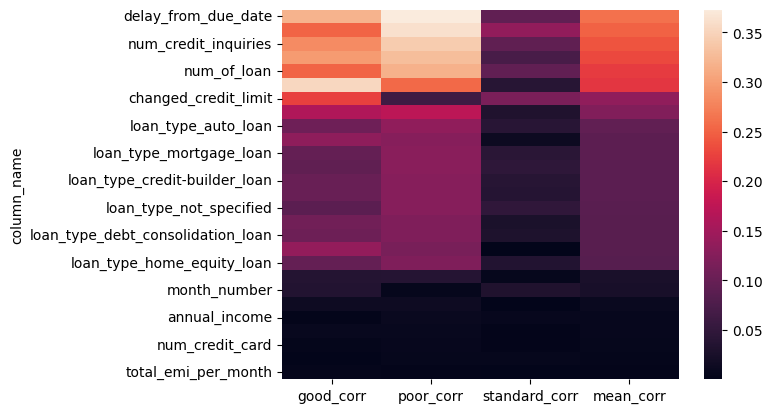

In [151]:
sns.heatmap(corr_df, fmt='.3f')

Let's see how many columns have really low average correlation. Let's say threshold is 0.01

In [152]:
deleted_columns = list(corr_df[corr_df.mean_corr < 0.01].index)
deleted_columns

['annual_income',
 'num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'total_emi_per_month']

It's only 5 columns which is not a lot. In my opinion it's better not to delete them and maybe they'll be usefull. 

In [153]:
features_df.to_csv("data/prepared_dataset.csv", index=False)

# Train val test split

In [154]:
df_full_train, df_test = train_test_split(features_df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [155]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [156]:
y_full_train = df_full_train.credit_score
y_train = df_train.credit_score
y_val = df_val.credit_score
y_test = df_test.credit_score

In [157]:
del df_full_train['credit_score']
del df_train['credit_score']
del df_val['credit_score']
del df_test['credit_score']

First of all let's see how features we have:

In [158]:
full_train_dicts = df_full_train.to_dict(orient='records')
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [159]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [160]:
list(dv.get_feature_names_out())

['age',
 'amount_invested_monthly',
 'annual_income',
 'changed_credit_limit',
 'credit_history_age',
 'credit_mix=Bad',
 'credit_mix=Good',
 'credit_mix=Standard',
 'credit_mix=_',
 'credit_utilization_ratio',
 'delay_from_due_date',
 'interest_rate',
 'loan_type_auto_loan',
 'loan_type_credit-builder_loan',
 'loan_type_debt_consolidation_loan',
 'loan_type_home_equity_loan',
 'loan_type_mortgage_loan',
 'loan_type_not_specified',
 'loan_type_payday_loan',
 'loan_type_personal_loan',
 'loan_type_student_loan',
 'month_number',
 'monthly_balance',
 'monthly_inhand_salary',
 'num_bank_accounts',
 'num_credit_card',
 'num_credit_inquiries',
 'num_of_delayed_payment',
 'num_of_loan',
 'outstanding_debt',
 'payment_of_min_amount=NM',
 'payment_of_min_amount=No',
 'payment_of_min_amount=Yes',
 'total_emi_per_month']

# Models

## Dummy model

Let's set dummy model that always predicts same values as a baseline.   
To do that let's see which value is the most popilar in the training + validation set

In [161]:
y_full_train.value_counts(normalize=True)

credit_score
Standard    0.531362
Poor        0.289187
Good        0.179450
Name: proportion, dtype: float64

Standard is the most popular value, so let's check accuracy we get on test set

In [162]:
float(np.sum(y_test == 'Standard') / len(y_test))

0.53325

Accuracy of this model on test dataset is 53.325%

## Logistic regression

In [163]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [164]:
# this code will remove warnings of model iteration limit
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [165]:
lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train) 

LogisticRegression(random_state=1)

In [166]:
y_pred = lr.predict(X_val)
y_pred

array(['Standard', 'Standard', 'Standard', ..., 'Standard', 'Standard',
       'Standard'], dtype=object)

In [167]:
?lr.score

Signature: lr.score(X, y, sample_weight=None)
Docstring:
Return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy
which is a harsh metric since you require for each sample that
each label set be correctly predicted.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Test samples.

y : array-like of shape (n_samples,) or (n_samples, n_outputs)
    True labels for `X`.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
score : float
    Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
File:      ~/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/base.py
Type:      method

In [168]:
lr.score(X_val, y_val)

0.53115

This score is really similar to dummy model. Let's try to fine tune it

Let's start with max_iter parameter

In [169]:
scores = []
for max_iter in tqdm([10, 50, 100, 200, 300, 400]):
    lr = LogisticRegression(max_iter=max_iter,  random_state=1)
    lr.fit(X_train, y_train) 
    mean_accuracy = lr.score(X_val, y_val)
    scores.append((max_iter, mean_accuracy))
df_scores = pd.DataFrame(scores, columns=['max_iter', 'mean_accuracy'])
df_scores.sort_values('mean_accuracy', ascending=False)

  0%|          | 0/6 [00:00<?, ?it/s]

,max_iter,mean_accuracy
3,200,0.56705
4,300,0.54185
5,400,0.54130
0,10,0.53165
2,100,0.53115
1,50,0.52555


Seems like the best results are for max_iter around 200

Let's try to play regularization strength 

In [170]:
scores = []

for C in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 50, 100, 1000]):
    for max_iter in [150, 175, 200, 225, 250]:    
        lr = LogisticRegression(C=C, max_iter=max_iter,  random_state=1)
        lr.fit(X_train, y_train) 
        mean_accuracy = lr.score(X_val, y_val)
        scores.append((C, max_iter, mean_accuracy))

  0%|          | 0/11 [00:00<?, ?it/s]

In [171]:
df_scores = pd.DataFrame(scores, columns=['C', 'max_iter', 'mean_accuracy'])
df_scores.sort_values('mean_accuracy', ascending=False).head()

,C,max_iter,mean_accuracy
38,10.00,225,0.59280
41,50.00,175,0.59240
39,10.00,250,0.59185
10,0.01,150,0.59165
18,0.10,225,0.59120


Let's see if other algorythms would give us better results:

In [172]:
scores = []
for algorythm in tqdm(['liblinear', 'sag', 'saga', 'newton-cg']):
    for C in [0.0001, 0.001, 0.01, 0.1, 5, 10]:
        for max_iter in [100, 150, 200, 250]:    
            lr = LogisticRegression(C=C, max_iter=max_iter,  random_state=1, solver=algorythm)
            lr.fit(X_train, y_train) 
            mean_accuracy = lr.score(X_val, y_val)
            scores.append((algorythm, C, max_iter, mean_accuracy))

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch

In [173]:
df_scores = pd.DataFrame(scores, columns=['algorythm', 'C', 'max_iter', 'mean_accuracy'])
df_scores.sort_values('mean_accuracy', ascending=False).head(20)

,algorythm,C,max_iter,mean_accuracy
91,newton-cg,5.0000,250,0.62865
87,newton-cg,0.1000,250,0.62825
95,newton-cg,10.0000,250,0.62805
90,newton-cg,5.0000,200,0.62790
82,newton-cg,0.0100,200,0.62755
83,newton-cg,0.0100,250,0.62750
94,newton-cg,10.0000,200,0.62745
86,newton-cg,0.1000,200,0.62730
89,newton-cg,5.0000,150,0.62440
81,newton-cg,0.0100,150,0.62415


Seems like newton-cg works best. Let's try to train it for more iterations:

In [174]:
scores = []
for C in tqdm([0.1, 1, 10]):
    for max_iter in [300, 400, 500]:    
        lr = LogisticRegression(C=C, max_iter=max_iter,  random_state=1, solver='newton-cg')
        lr.fit(X_train, y_train) 
        mean_accuracy = lr.score(X_val, y_val)
        scores.append((C, max_iter, mean_accuracy))

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch

In [175]:
df_scores = pd.DataFrame(scores, columns=['C', 'max_iter', 'mean_accuracy'])
df_scores.sort_values('mean_accuracy', ascending=False).head(20)

,C,max_iter,mean_accuracy
7,10.0,400,0.62865
2,0.1,500,0.62840
4,1.0,400,0.62840
5,1.0,500,0.62840
1,0.1,400,0.62835
8,10.0,500,0.62825
3,1.0,300,0.62810
6,10.0,300,0.62800
0,0.1,300,0.62785


In [176]:
max_iter=400
C=10

Final model results:

In [177]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

In [178]:
lr = LogisticRegression(C=C, max_iter=max_iter,  random_state=1, solver='newton-cg')
lr.fit(X_full_train, y_full_train)	
score = lr.score(X_test, y_test)
print(f"score: {score}")

/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/vpankrat/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


score: 0.6347


Confusion matrix on a test set:

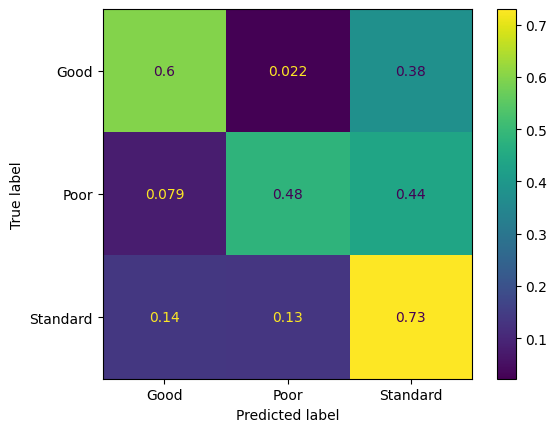

In [179]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, normalize='true')

Final score for Logistic regression is 63.48% mean accuracy

## Decision Tree

In [180]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [181]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [182]:
y_pred = dt.predict(X_val)
y_pred

array(['Standard', 'Poor', 'Poor', ..., 'Good', 'Good', 'Poor'],
      dtype=object)

In [183]:
?dt.score

Signature: dt.score(X, y, sample_weight=None)
Docstring:
Return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy
which is a harsh metric since you require for each sample that
each label set be correctly predicted.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Test samples.

y : array-like of shape (n_samples,) or (n_samples, n_outputs)
    True labels for `X`.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
score : float
    Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
File:      ~/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/base.py
Type:      method

In [184]:
dt.score(X_val, y_val)

0.6959

Result is clearly not the best with mean accuracy of only 69.59%. Let's fine tune this model

In [185]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 35, 40, 50, None]:
    dt = DecisionTreeClassifier(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)
    mean_accuracy = dt.score(X_val, y_val)
    print(f'Max depth: {d}, mean_accuracy: {mean_accuracy}')

Max depth: 1, mean_accuracy: 0.60165
Max depth: 2, mean_accuracy: 0.6074
Max depth: 3, mean_accuracy: 0.6514
Max depth: 4, mean_accuracy: 0.66755
Max depth: 5, mean_accuracy: 0.67645
Max depth: 6, mean_accuracy: 0.69855
Max depth: 10, mean_accuracy: 0.70705
Max depth: 15, mean_accuracy: 0.7068
Max depth: 20, mean_accuracy: 0.70985
Max depth: 25, mean_accuracy: 0.7044
Max depth: 30, mean_accuracy: 0.6997
Max depth: 35, mean_accuracy: 0.6969
Max depth: 40, mean_accuracy: 0.6955
Max depth: 50, mean_accuracy: 0.6959
Max depth: None, mean_accuracy: 0.6959


The best value for tree depth is d = 10 with mean accuracy of 70.7%

In [186]:
scores = []
for d in tqdm([5, 8, 9, 10, 11, 12, 15, 20, 25, 30]):
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(
            max_depth=d,
            min_samples_leaf=s,
            random_state=1
        )
        dt.fit(X_train, y_train)
        mean_accuracy = dt.score(X_val, y_val)
        scores.append((d, s, mean_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

In [187]:
columns = ['max_depth', 'min_samples_leaf', 'mean_accuracy']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='mean_accuracy', ascending=False).head(10)

,max_depth,min_samples_leaf,mean_accuracy
63,20,1,0.70985
64,20,2,0.70795
32,10,20,0.70780
27,10,1,0.70705
51,12,100,0.70705
55,15,2,0.70695
28,10,2,0.70685
54,15,1,0.70680
19,9,2,0.70660
31,10,15,0.70635


In [188]:
df_scores_pivot = df_scores.pivot(
	index='min_samples_leaf', 
	columns=['max_depth'],
	values =['mean_accuracy']
)
df_scores_pivot.round(3)

mean_accuracy                                            \
max_depth                   5      8      9      10     11     12     15   
min_samples_leaf                                                           
1                        0.676  0.705  0.706  0.707  0.702  0.704  0.707   
2                        0.676  0.705  0.707  0.707  0.702  0.704  0.707   
5                        0.676  0.705  0.706  0.706  0.700  0.701  0.704   
10                       0.676  0.703  0.705  0.705  0.700  0.702  0.703   
15                       0.676  0.702  0.705  0.706  0.702  0.703  0.705   
20                       0.676  0.704  0.705  0.708  0.701  0.704  0.706   
100                      0.676  0.703  0.706  0.706  0.706  0.707  0.704   
200                      0.676  0.704  0.705  0.705  0.706  0.704  0.704   
500                      0.667  0.689  0.689  0.688  0.689  0.689  0.689   

                                       
max_depth            20     25     30  
min_samples_leaf                       
1                 0.710  0.704  0.700  
2                 0.708  0.698  0.694  
5                 0.701  0.694  0.692  
10                0.702  0.701  0.702  
15                0.704  0.705  0.706  
20                0.703  0.706  0.706  
100               0.705  0.705  0.705  
200               0.704  0.704  0.704  
500               0.689  0.689  0.689

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

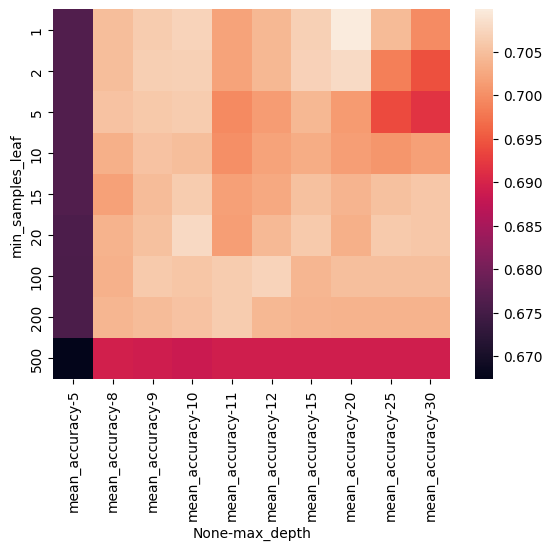

In [189]:
sns.heatmap(df_scores_pivot, fmt='.3f')

It seems like the best combination is for:

In [190]:
min_samples_leaf=1
max_depth = 15

Final result of DecisionTreeClassifier:

In [191]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

In [192]:
dt = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
dt.fit(X_full_train, y_full_train)	
score = dt.score(X_test, y_test)
print(f"score: {score}")

score: 0.71375


Confusion matrics on test set:

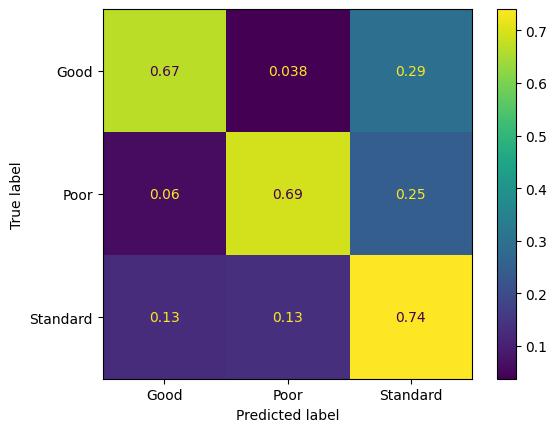

In [193]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, normalize='true')

Final score for Decision tree is 71.45% mean accuracy

## Random Forest

In [194]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [195]:
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [196]:
y_pred = rf.predict(X_val)
y_pred

array(['Standard', 'Poor', 'Poor', ..., 'Good', 'Standard', 'Poor'],
      dtype=object)

In [197]:
?rf.score

Signature: rf.score(X, y, sample_weight=None)
Docstring:
Return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy
which is a harsh metric since you require for each sample that
each label set be correctly predicted.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Test samples.

y : array-like of shape (n_samples,) or (n_samples, n_outputs)
    True labels for `X`.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
score : float
    Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
File:      ~/opt/anaconda3/envs/midterm_project/lib/python3.10/site-packages/sklearn/base.py
Type:      method

In [198]:
rf.score(X_val, y_val)

0.77115

Initial score for Random Forest is already better than for decision tree. Let's fine tune it now.

In [199]:
scores = []
for n in tqdm(range(10, 401, 10)):
	rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
	rf.fit(X_train, y_train)
	mean_accuracy = rf.score(X_val, y_val)
	scores.append((n, mean_accuracy))

  0%|          | 0/40 [00:00<?, ?it/s]

In [200]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mean_accuracy'])
df_scores.sort_values('mean_accuracy', ascending=False).head()

,n_estimators,mean_accuracy
39,400,0.80000
38,390,0.80000
29,300,0.79990
37,380,0.79980
25,260,0.79975


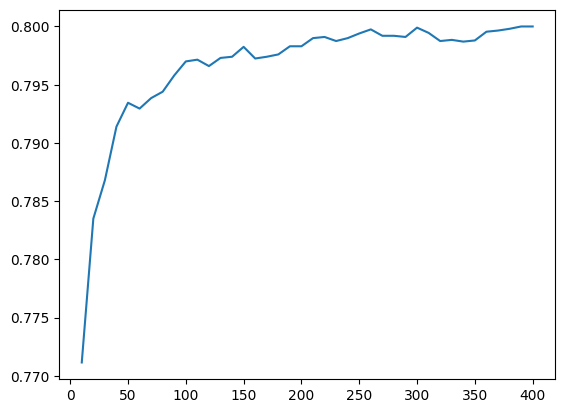

In [201]:
plt.plot(df_scores.n_estimators, df_scores.mean_accuracy)

We can see that model performance hits peak at about 300 - 350 trees in the forest

Now let's calculate best depth for the forest

In [202]:
scores = []
for d in tqdm(range(10, 81, 10)):
    for n in [200, 300, 325, 350, 400]:
        rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth=d,
            random_state=1, 
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        mean_accuracy = rf.score(X_val, y_val)
        scores.append((d, n, mean_accuracy))

  0%|          | 0/8 [00:00<?, ?it/s]

In [203]:
columns = ['max_depth', 'n_estimators', 'mean_accuracy']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values('mean_accuracy', ascending=False).head()

,max_depth,n_estimators,mean_accuracy
19,40,400,0.80055
24,50,400,0.80015
34,70,400,0.80000
39,80,400,0.80000
29,60,400,0.80000


Mean scores for max_depths:

In [204]:
df_scores.groupby('max_depth').mean().sort_values('mean_accuracy', ascending=False)

,n_estimators,mean_accuracy
max_depth,,
40,315.0,0.79919
60,315.0,0.79915
70,315.0,0.79915
80,315.0,0.79915
50,315.0,0.79903
30,315.0,0.79823
20,315.0,0.78197
10,315.0,0.72112


In [205]:
max_depth = 40

Let's find optimal leaf size

In [206]:
scores = []
for s in tqdm([1, 3, 5, 10, 50]):
    for n in [200, 300, 325, 350, 400]:
        rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth=max_depth,
            min_samples_leaf=s,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        mean_accuracy = rf.score(X_val, y_val)
        scores.append((s, n, mean_accuracy))

  0%|          | 0/5 [00:00<?, ?it/s]

In [207]:
columns = ['min_samples_leaf', 'n_estimators', 'mean_accuracy']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head().sort_values('mean_accuracy', ascending=False).head()

,min_samples_leaf,n_estimators,mean_accuracy
4,1,400,0.80055
3,1,350,0.79960
1,1,300,0.79955
2,1,325,0.79855
0,1,200,0.79770


In [208]:
df_scores.groupby('min_samples_leaf').mean().sort_values('mean_accuracy', ascending=False)

,n_estimators,mean_accuracy
min_samples_leaf,,
1,315.0,0.79919
3,315.0,0.78649
5,315.0,0.77620
10,315.0,0.76114
50,315.0,0.72607


In [209]:
min_samples_leaf = 1

Let's see model progress with optimal depth and min_samples_leaf

In [210]:
scores = []
for n in tqdm(range(40, 401, 40)):
    rf = RandomForestClassifier(
    	n_estimators=n, 
    	max_depth=max_depth,
    	min_samples_leaf=min_samples_leaf,
    	random_state=1,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    mean_accuracy = rf.score(X_val, y_val)
    scores.append((n, mean_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Best results:    n_estimators  mean_accuracy
9           400        0.80055


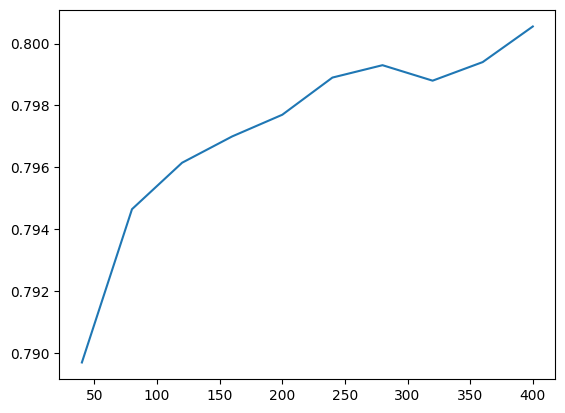

In [211]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mean_accuracy'])
print(f"Best results: {df_scores.sort_values('mean_accuracy', ascending=False).head(1)}")
plt.plot(df_scores.n_estimators, df_scores.mean_accuracy)

Let's also try using bootstrap for this model

In [212]:
scores = []
for n in tqdm(range(40, 401, 40)):
    rf = RandomForestClassifier(
    	n_estimators=n, 
    	max_depth=max_depth,
    	min_samples_leaf=min_samples_leaf,
    	random_state=1,
        bootstrap=True,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    mean_accuracy = rf.score(X_val, y_val)
    scores.append((n, mean_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Best results:    n_estimators  mean_accuracy
9           400        0.80055


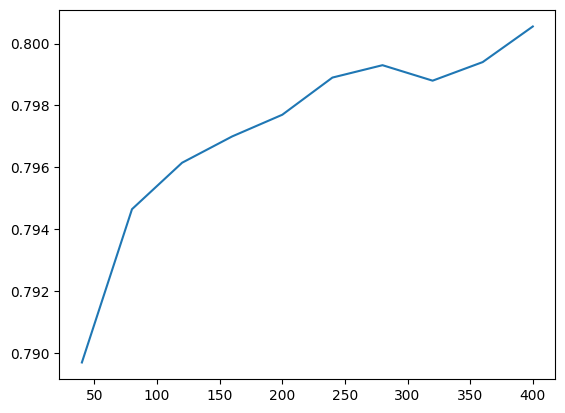

In [213]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mean_accuracy'])
print(f"Best results: {df_scores.sort_values('mean_accuracy', ascending=False).head(1)}")
plt.plot(df_scores.n_estimators, df_scores.mean_accuracy)

Let's also try warm_start parameter

In [214]:
scores = []
for n in tqdm(range(40, 401, 40)):
    rf = RandomForestClassifier(
    	n_estimators=n, 
    	max_depth=max_depth,
    	min_samples_leaf=min_samples_leaf,
    	random_state=1,
        bootstrap=True,
        warm_start=True,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    mean_accuracy = rf.score(X_val, y_val)
    scores.append((n, mean_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Best results:    n_estimators  mean_accuracy
9           400        0.80055


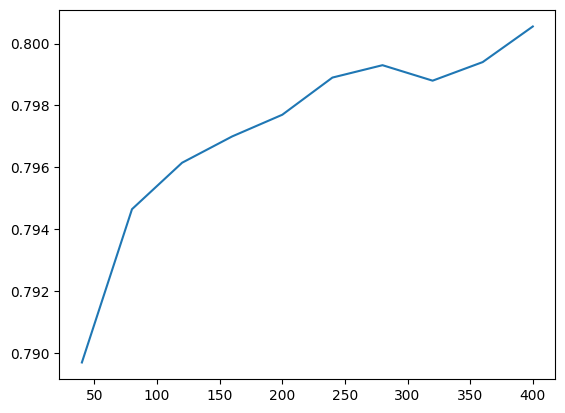

In [215]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mean_accuracy'])
print(f"Best results: {df_scores.sort_values('mean_accuracy', ascending=False).head(1)}")
plt.plot(df_scores.n_estimators, df_scores.mean_accuracy)

In [216]:
max_depth = 280

Well it seems like we got the best out of this model, let's try it on all training data and test on the testing dataset

In [217]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

In [218]:
rf = RandomForestClassifier(
    n_estimators=n, 
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=1,
    bootstrap=True,
    warm_start=True,
    n_jobs=-1
)
rf.fit(X_full_train, y_full_train)	
score = rf.score(X_test, y_test)
print(f"score: {score}")

score: 0.8114


Well you look at that our model perfomed even a bit better on a testing set, cause it got more training data.

Confusion matrics on test set:

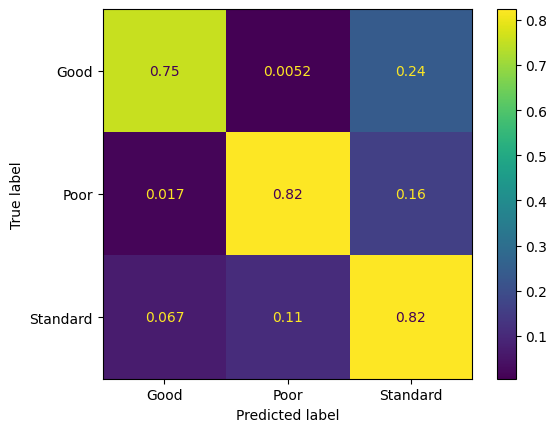

In [219]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')

Final score for Random Forest model  is 81.12% mean accuracy

## XGboost

In [220]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [221]:
y_full_train_maped = y_full_train.map({'Good': 0, 'Poor': 1, 'Standard': 2})
y_train_maped = y_train.map({'Good': 0, 'Poor': 1, 'Standard': 2})
y_val_maped = y_val.map({'Good': 0, 'Poor': 1, 'Standard': 2})
y_test_maped = y_test.map({'Good': 0, 'Poor': 1, 'Standard': 2})

In [222]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(
	X_train,
	label=y_train_maped, 
	feature_names=features
)

dval = xgb.DMatrix(
	X_val,
	label=y_val_maped, 
	feature_names=features
)

In [223]:
xgb_params = {
    'num_class': 3,
	'objective': 'multi:softmax',
	'nthreads': 8, # number of cores
	
	'seed': 1,
	'verbosity': 1
}
model = xgb.train(
	xgb_params,
	dtrain,
	num_boost_round=200
)

In [224]:
y_pred = model.predict(dval)
y_pred

array([2., 1., 1., ..., 0., 2., 2.], dtype=float32)

In [225]:
accuracy_score(y_pred, y_val_maped)

0.7783

Not bad. Let's fine tune it

In [226]:
scores = []
for eta in [3, 1, 0.3, 0.1, 0.05, 0.01]:
    xgb_params = {
        'eta': eta,
        'num_class': 3,
    	'objective': 'multi:softmax',
    	'nthreads': 8, # number of cores
    	
    	'seed': 1,
    	'verbosity': 1
    }
    model = xgb.train(
    	xgb_params,
    	dtrain,
    	num_boost_round=200
    )
    y_pred = model.predict(dval)

    mean_accuracy = accuracy_score(y_pred, y_val_maped)
    scores.append((eta, mean_accuracy))

In [227]:
columns = ['eta', 'mean_accuracy']
mi_scores_df = pd.DataFrame(scores, columns=columns)
mi_scores_df.sort_values('mean_accuracy', ascending=False)

,eta,mean_accuracy
2,0.30,0.77830
1,1.00,0.77695
3,0.10,0.74400
4,0.05,0.72545
5,0.01,0.71140
0,3.00,0.54105


In [228]:
eta = 0.3

In [229]:
scores = []
for d in range(1, 21, 2):
    xgb_params = {
        'eta': eta,
        'max_depth': d,
        'num_class': 3,
    	'objective': 'multi:softmax',
    	'nthreads': 8, # number of cores
    	
    	'seed': 1,
    	'verbosity': 1
    }
    model = xgb.train(
    	xgb_params,
    	dtrain,
    	num_boost_round=200
    )
    y_pred = model.predict(dval)

    mean_accuracy = accuracy_score(y_pred, y_val_maped)
    scores.append((d, mean_accuracy))

In [230]:
columns = ['max_depth', 'mean_accuracy']
mi_scores_df = pd.DataFrame(scores, columns=columns)
mi_scores_df.sort_values('mean_accuracy', ascending=False).head(5)

,max_depth,mean_accuracy
7,15,0.80675
6,13,0.80540
8,17,0.80425
9,19,0.80275
5,11,0.80270


In [231]:
max_depth = 15

In [232]:
scores = []
for min_child_weight in [1, 2, 3, 4,  5, 10, 20]:
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'num_class': 3,
    	'objective': 'multi:softmax',
    	'nthreads': 8, # number of cores
    	
    	'seed': 1,
    	'verbosity': 1
    }
    model = xgb.train(
    	xgb_params,
    	dtrain,
    	num_boost_round=200
    )
    y_pred = model.predict(dval)

    mean_accuracy = accuracy_score(y_pred, y_val_maped)
    scores.append((min_child_weight, mean_accuracy))

In [233]:
columns = ['min_child_weight', 'mean_accuracy']
mi_scores_df = pd.DataFrame(scores, columns=columns)
mi_scores_df.sort_values('mean_accuracy', ascending=False).head(5)

,min_child_weight,mean_accuracy
0,1,0.80675
1,2,0.80670
2,3,0.80565
4,5,0.80360
3,4,0.80330


In [234]:
min_child_weight = 1

Okay, we tuned this model enough. Let't test it on testing dataset

In [235]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)

In [236]:
features = list(dv.get_feature_names_out())
dfull_train = xgb.DMatrix(
	X_full_train,
	label=y_full_train_maped, 
	feature_names=features
)

dtest = xgb.DMatrix(
	X_test,
	label=y_test_maped, 
	feature_names=features
)

In [237]:
xgb_params = {
    'eta': eta,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'num_class': 3,
    'objective': 'multi:softmax',
    'nthreads': 8, # number of cores
    
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(
    xgb_params,
    dfull_train,
    num_boost_round=200
)
y_pred = model.predict(dtest)

score = accuracy_score(y_pred, y_test_maped)
print(f"score: {score}")

score: 0.821


Confusion matrics on test set:

In [238]:
y_pred

array([1., 1., 2., ..., 1., 1., 0.], dtype=float32)

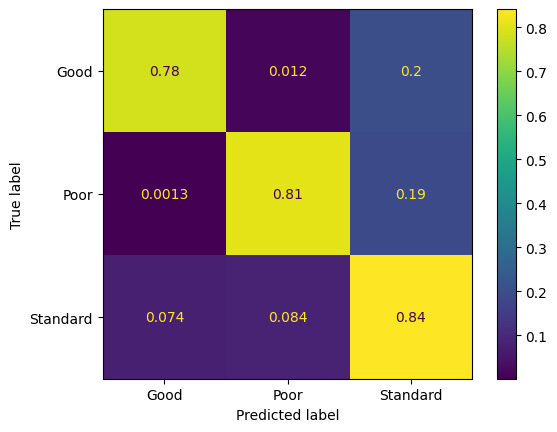

In [239]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test_maped, normalize='true'), 
    display_labels=['Good', 'Poor', 'Standard']
)
disp.plot()

Final score for XGBoost model on a test set is 82.1% 

# Final results

## Model performances on a test set:
1. Dummy model: 53%
2. Logistic Regression: 63.48%
3. Decision Tree: 71.45%
4. Random Forest: 81.12%
5. XGboost: 82.1%

So we will use xgboost model since it gives the best results